In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [25]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [26]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [27]:
plt.style.use("ggplot")

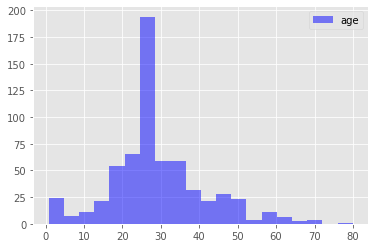

In [28]:
dftrain["age"].hist(bins=20,color="b",legend = True,alpha = 0.50) #Distribution of the age
plt.show() 

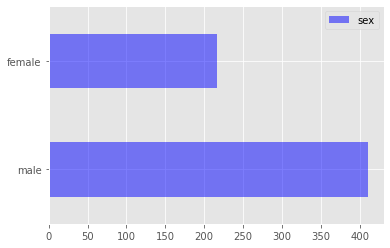

In [29]:
dftrain["sex"].value_counts().plot(kind='barh',alpha=0.5,color="b",legend=True)
plt.show()

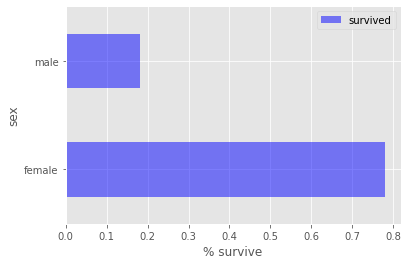

In [30]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh',
                                                                          color="b",
                                                                          legend=True,
                                                                          alpha=0.5).set_xlabel('% survive')
plt.show()

-Most passengers are in their 20's or 30's
-Most passengers are male
-Most passengers are in "Third" class
-Females have a much higher chance of survival

In [31]:
#dividing categorical data from numericas data
def cat_vs_num(df):
    cat_cols = list()
    num_cols = list()
    for col in df.columns:
        if df[col].dtype == "float64":
            num_cols.append(col)
        else:
            cat_cols.append(col)
    return num_cols,cat_cols

num_cols_train,cat_cols_train = cat_vs_num(dftrain)
print(num_cols_train,cat_cols_train)

['age', 'fare'] ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']


In [33]:
feature_columns = list()
for feature_name in cat_cols_train:
    uni_values = dftrain[feature_name].unique() #unique values for every feature in the data set
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,uni_values))

for feature_name in num_cols_train:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float64))
print(feature_columns)

#in the tutorial I am following they did not clean the data, or gave a proper treat to missing values, is recomedable to do it.
#for now I will continue as the tutorial goes.

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def